# Aligning HST Mosaics 

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

# Introduction

This notebook demonstrates how to align and drizzle mosaicked tiles of the Eagle Nebula (M16) obtained with WFC3 with both UVIS and IR detectors. It is based on the example highlighted in the following WFC3 technical report: [ISR 2015-09: Combining WFC3 Mosaics of M16 with DrizzlePac](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-09.pdf)
and highlights special features in DrizzlePac to improve mosaics. 

In prior alignment [tutorials](https://archive.stsci.edu/prepds/heritage/horsehead/readme_HLSP_v3.txt), building up an aligned set of tiles required an iterative approach. Now, mosaic alignment can be achieved in a single step by building up an expanded reference catalog ‘on-the-fly’. New sky matching options make it easier to produce seamless mosaics, which can be challenging for extended sources with little or no blank sky. 

In [1]:
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
from astropy.table import Table
from astropy.io import fits
from astropy.io import ascii
from astropy.visualization import ZScaleInterval
from IPython.display import Image
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


# 1. Observations

Mosaics of the Eagle Nebula were acquired by HST GO/DD [program 13926](http://www.stsci.edu/cgi-bin/get-proposal-info?id=13926&observatory=HST) in September 2014 for HST's 25th Annivery. A 2x2 tile mosaic with the IR detector (~4 arcmin across) was observed in the F110W and F160W filters. 

A slightly larger 2x2 mosaic with the UVIS detector (~5 arcmin across) was observed with the F502N, F657N, and F673N filters. Small dithers between exposures in a given tile will fill in the UVIS chip gap and allow for the rejection of cosmic rays and detector artifacts. More detail on the observing strategy may be found in the [Phase II file](http://www.stsci.edu/hst/phase2-public/13926.pro).

Two additional UVIS tiles overlap the central portion of 2x2 mosaic in order to have very high signal-to-noise in the Eagle's pillars. These two visits (09,10) were not included in this example for brevity. The data used in this notebook example is also limited to the IR/F160W filter (visits 01-04) and UVIS/F657N filters (visits 05-08), shown in the diagrams below.
>      IR Mosaic           UVIS Mosaic         UVIS(overlap)
>      ____ ____            ____ ____            ____ 
>     |    |    |          |    |    |          |    |   
>     | 02 | 01 |          | 06 | 05 |          | 09 | 
>     |____|____|          |____|____|          |____|
>     |    |    |          |    |    |          |    |  
>     | 04 | 03 |          | 08 | 07 |          | 10 |
>     |____|____|          |____|____|          |____|

# 2. MAST Download

In the steps below, the calibrated IR data (\*\_flt.fits) and the calibrated, CTE-corrected UVIS data (\*\_flc.fits) are retrieved from MAST and placed in the same directory as this notebook, along with the associated telemetry and engineering files (\*\_spt.fits).

In [2]:
# Retrieve the IR/F160W calibrated FLT and SPT data products  
science_list = Observations.query_criteria(proposal_id='13926', filters='F160W')
Observations.download_products(science_list['obsid'], mrp_only=False, download_dir='./science',
                               productSubGroupDescription=['FLT', 'SPT'])

science_files = glob.glob(os.path.join(os.curdir, 'science', 'mastDownload', 'HST', '*', '*fits'))
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im, './' + root)
shutil.rmtree('science/')

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


In [3]:
# Obtain the UVIS/F657N calibrated FLC and SPT data products from visits 05-08 
science_list = Observations.query_criteria(proposal_id='13926', filters='F657N', obs_id='ICK90[5678]*')
Observations.download_products(science_list['obsid'], mrp_only=False, download_dir='./science',
                               productSubGroupDescription=['FLC', 'SPT'])

science_files = glob.glob(os.path.join(os.curdir, 'science', 'mastDownload', 'HST', '*', '*fits'))
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im, './' + root)
shutil.rmtree('science/')

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


# 3. Dithers

## 3a. IR detector
IR exposures were obtained in Visits 01-04. (The visit ID is found in the 5th and 6th character of the filename). Each visit (mosaic tile) consists of a pair of exposures using the WFC3-IR-DITHER-BLOB dither of 7.2" along the y-axis (pattern_orient=90 degrees). This dither can be seen when comparing the POSTARG2 keyword between pairs of exposures in a given visit in the table below. 

Pairs of IR exposures making up each visit are referred to as v01a and v01b in this notebook. The first four images listed in the table below are associated with v01a and the last four with v01b. 

In [4]:
collect_ir = ImageFileCollection('./', glob_include="*flt.fits", ext=0,
                                 keywords=["asn_id", "detector", "filter", "nsamp",
                                           "exptime", "postarg1", "postarg2"])

ir_table = collect_ir.summary
ir_table['exptime'].format = '7.1f'
ir_table['postarg1'].format = '7.2f'
ir_table['postarg2'].format = '7.2f'
ir_table

<Table masked=True length=8>
       file          asn_id  detector filter nsamp exptime postarg1 postarg2
      str18           str9     str2    str5  int64 float64 float64  float64 
------------------ --------- -------- ------ ----- ------- -------- --------
ick901hzq_flt.fits ICK901030       IR  F160W    16   702.9   -62.57   -62.05
ick901i7q_flt.fits ICK901030       IR  F160W    16   702.9   -62.57   -54.85
ick902n9q_flt.fits ICK902030       IR  F160W    16   702.9    62.57   -62.05
ick902neq_flt.fits ICK902030       IR  F160W    16   702.9    62.57   -54.85
ick903n4q_flt.fits ICK903030       IR  F160W    16   702.9   -62.57    54.85
ick903ncq_flt.fits ICK903030       IR  F160W    16   702.9   -62.57    62.05
ick904obq_flt.fits ICK904030       IR  F160W    16   702.9    62.57    54.85
ick904ogq_flt.fits ICK904030       IR  F160W    16   702.9    62.57    62.05

## 3b. UVIS detector

UVIS exposures were acquired in Visits 05-08. Each UVIS visit (tile) consists of a set of 3 dithered exposures using the WFC3-UVIS-MOSAIC-LINE pattern, with an offset ~12" along a 65 degree diagonal. This dither can be seen in the POSTARG1, POSTARG2 offsets which are ~5" in X and ~10" in Y between exposures in a given visit. 

Sets of three exposures making up each UVIS visit are referred to as v05a, v05b, v05c in this notebook.

In [5]:
collect_uvis = ImageFileCollection('./', glob_include="*flc.fits", ext=0,
                                   keywords=["asn_id", "detector", "filter", "exptime", "postarg1", "postarg2"])
    
uvis_table = collect_uvis.summary
uvis_table['exptime'].format = '7.1f'
uvis_table['postarg1'].format = '7.2f'
uvis_table['postarg2'].format = '7.2f'
uvis_table

<Table masked=True length=12>
       file          asn_id  detector filter exptime postarg1 postarg2
      str18           str9     str4    str5  float64 float64  float64 
------------------ --------- -------- ------ ------- -------- --------
ick905k5q_flc.fits ICK905040     UVIS  F657N   600.0   -65.38   -74.27
ick905keq_flc.fits ICK905040     UVIS  F657N   600.0   -60.31   -63.40
ick905knq_flc.fits ICK905040     UVIS  F657N   600.0   -55.24   -52.52
ick906kwq_flc.fits ICK906040     UVIS  F657N   600.0    65.38   -65.13
ick906l5q_flc.fits ICK906040     UVIS  F657N   600.0    70.46   -54.25
ick906leq_flc.fits ICK906040     UVIS  F657N   600.0    75.53   -43.38
ick907nkq_flc.fits ICK907040     UVIS  F657N   600.0   -65.38    65.13
ick907o1q_flc.fits ICK907040     UVIS  F657N   600.0   -60.31    76.00
ick907ouq_flc.fits ICK907040     UVIS  F657N   600.0   -55.24    86.88
ick908pbq_flc.fits ICK908040     UVIS  F657N   600.0    65.38    74.27
ick908pkq_flc.fits ICK908040     UVIS  F657N   600.0    70.46    85.15
ick908ptq_flc.fits ICK908040     UVIS  F657N   600.0    75.53    96.02

# 4. TweakReg for Mosaics

Before combining observations with AstroDrizzle, the WCS keywords in the header of each input frame
should be aligned to sub-pixel accuracy. This may be achieved with TweakReg, which allows users to align sets of images to one another or to an external astrometric reference frame. TweakReg has been enhanced to support the alignment of observations that cover a large area on the sky. Making use of the `expand_refcat` parameter, TweakReg will build up an expanded reference catalog on the sky to be used for alignment. When set to 'True', TweakReg selects two images from the input list with the largest overlap on the sky, generates source catalogs for each image, and computes a fit (shift, rotation, and/or scale change) from the matched source list. 

Next, the algorithm computes the area of overlap of each of these two images with the rest of the input images, and the one with the largest total overlap on the sky is selected as the reference image. Sources from the second image that have not been matched to the reference image catalog are considered good new sources and are added to the reference catalog. In this way, the reference catalog keeps expanding with each new matched image. With a large (expanded) reference catalog it is therefore possible to align images that had no direct overlap with the starting image.

## 4a. IR Alignment

For this large multi-filter dataset, the user should carefully consider which observations to align and combine first. These will serve as a reference image for aligning additional filters. The broadband IR images of M16 contain a large number of stars distributed uniformly over the field of view. The UVIS frames, on the other hand, are largely devoid of point sources and full of cosmic-rays which can trip up TweakReg when trying to compute a fit. Even though the IR detector has a smaller footprint on the sky and the IR PSF is more undersampled, the high density of stars makes it a better anchor for aligning the UVIS tiles.

Of the two IR filters, F160W has the largest number of point sources and therefore makes a good choice for the reference image. To generate source lists for matching, the TweakReg parameter `conv_width` should be set to approximately twice the FWHM of the PSF, ~2.5 pixels for IR observations and ~3.5 pixels for UVIS observations. TweakReg will automatically compute the standard deviation of the sky background (`skysigma`), so the number of sources in each catalog may be controlled simply by changing the ‘threshold’ parameter. 

In this example, TweakReg is run in ‘non-interactive’ mode (`interactive='False'`) so that the astrometric fit residuals and vectors diagrams will be saved as png files in the user’s local directory for inspection. Once the parameters have been fine-tuned and the fit looks adequate, users may run TweakReg a second time (see below) to update the image header WCS keywords by setting the parameter `updatehdr` to True.

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 01:14:57.528 (18/12/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 01:14:57.528 (18/12/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.5 (default, Oct 25 2019, 10:52:18) 


3.7.5 (default, Oct 25 2019, 10:52:18) 


INFO:drizzlepac.util:numpy Version -> 1.17.4 


numpy Version -> 1.17.4 


INFO:drizzlepac.util:astropy Version -> 3.2.3 


astropy Version -> 3.2.3 


INFO:drizzlepac.util:stwcs Version -> 1.5.3 


stwcs Version -> 1.5.3 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	False


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	True


INFO:drizzlepac.tweakreg:	input :	*flt.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    ick901hzq_flt.fits


    ick901hzq_flt.fits


INFO:drizzlepac.tweakreg:    ick901i7q_flt.fits


    ick901i7q_flt.fits


INFO:drizzlepac.tweakreg:    ick902n9q_flt.fits


    ick902n9q_flt.fits


INFO:drizzlepac.tweakreg:    ick902neq_flt.fits


    ick902neq_flt.fits


INFO:drizzlepac.tweakreg:    ick903n4q_flt.fits


    ick903n4q_flt.fits


INFO:drizzlepac.tweakreg:    ick903ncq_flt.fits


    ick903ncq_flt.fits


INFO:drizzlepac.tweakreg:    ick904obq_flt.fits


    ick904obq_flt.fits


INFO:drizzlepac.tweakreg:    ick904ogq_flt.fits


    ick904ogq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	2.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	False


INFO:drizzlepac.tweakreg:	expand_refcat :	True


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flt.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	50


INFO:drizzlepac.tweakreg:	updatehdr :	True


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick901hzq_flt.fits':


===  Source finding for image 'ick901hzq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick901hzq_flt.fits', EXT=('SCI', 1) started at: 01:14:57.614 (18/12/2019)


  #  Source finding for 'ick901hzq_flt.fits', EXT=('SCI', 1) started at: 01:14:57.614 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.025950


INFO:drizzlepac.catalogs:###Source finding finished at: 01:14:57.735 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 546 objects.


     Found 546 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick901hzq_flt.fits': 546


===  FINAL number of objects in image 'ick901hzq_flt.fits': 546


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick901i7q_flt.fits':


===  Source finding for image 'ick901i7q_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick901i7q_flt.fits', EXT=('SCI', 1) started at: 01:14:57.805 (18/12/2019)


  #  Source finding for 'ick901i7q_flt.fits', EXT=('SCI', 1) started at: 01:14:57.805 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.064600


INFO:drizzlepac.catalogs:###Source finding finished at: 01:14:57.942 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 521 objects.


     Found 521 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick901i7q_flt.fits': 521


===  FINAL number of objects in image 'ick901i7q_flt.fits': 521


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick902n9q_flt.fits':


===  Source finding for image 'ick902n9q_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick902n9q_flt.fits', EXT=('SCI', 1) started at: 01:14:58.015 (18/12/2019)


  #  Source finding for 'ick902n9q_flt.fits', EXT=('SCI', 1) started at: 01:14:58.015 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.445831


INFO:drizzlepac.catalogs:###Source finding finished at: 01:14:58.152 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 574 objects.


     Found 574 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick902n9q_flt.fits': 574


===  FINAL number of objects in image 'ick902n9q_flt.fits': 574


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick902neq_flt.fits':


===  Source finding for image 'ick902neq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick902neq_flt.fits', EXT=('SCI', 1) started at: 01:14:58.225 (18/12/2019)


  #  Source finding for 'ick902neq_flt.fits', EXT=('SCI', 1) started at: 01:14:58.225 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.447646


INFO:drizzlepac.catalogs:###Source finding finished at: 01:14:58.360 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 602 objects.


     Found 602 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick902neq_flt.fits': 602


===  FINAL number of objects in image 'ick902neq_flt.fits': 602


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick903n4q_flt.fits':


===  Source finding for image 'ick903n4q_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick903n4q_flt.fits', EXT=('SCI', 1) started at: 01:14:58.445 (18/12/2019)


  #  Source finding for 'ick903n4q_flt.fits', EXT=('SCI', 1) started at: 01:14:58.445 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.500067


INFO:drizzlepac.catalogs:###Source finding finished at: 01:14:58.555 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 479 objects.


     Found 479 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick903n4q_flt.fits': 479


===  FINAL number of objects in image 'ick903n4q_flt.fits': 479


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick903ncq_flt.fits':


===  Source finding for image 'ick903ncq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick903ncq_flt.fits', EXT=('SCI', 1) started at: 01:14:58.62 (18/12/2019)


  #  Source finding for 'ick903ncq_flt.fits', EXT=('SCI', 1) started at: 01:14:58.62 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.463412


INFO:drizzlepac.catalogs:###Source finding finished at: 01:14:58.74 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 495 objects.


     Found 495 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick903ncq_flt.fits': 495


===  FINAL number of objects in image 'ick903ncq_flt.fits': 495


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick904obq_flt.fits':


===  Source finding for image 'ick904obq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick904obq_flt.fits', EXT=('SCI', 1) started at: 01:14:58.818 (18/12/2019)


  #  Source finding for 'ick904obq_flt.fits', EXT=('SCI', 1) started at: 01:14:58.818 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.431873


INFO:drizzlepac.catalogs:###Source finding finished at: 01:14:58.935 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 476 objects.


     Found 476 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick904obq_flt.fits': 476


===  FINAL number of objects in image 'ick904obq_flt.fits': 476


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick904ogq_flt.fits':


===  Source finding for image 'ick904ogq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick904ogq_flt.fits', EXT=('SCI', 1) started at: 01:14:59.002 (18/12/2019)


  #  Source finding for 'ick904ogq_flt.fits', EXT=('SCI', 1) started at: 01:14:59.002 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.437439


INFO:drizzlepac.catalogs:###Source finding finished at: 01:14:59.119 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 445 objects.


     Found 445 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick904ogq_flt.fits': 445


===  FINAL number of objects in image 'ick904ogq_flt.fits': 445


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "ick902neq_flt.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'ick902neq_flt.fits'


derived from 'ick902neq_flt.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	2.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	True


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	rscale


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	3.0


INFO:drizzlepac.tweakreg:	ylimit :	0.3


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	shift160_flt.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick902n9q_flt.fits


Performing fit for: ick902n9q_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick902n9q_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick902n9q_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.3511, 0.413 with significance of 243.6 and 523 matches


Found initial X and Y shifts of 0.3511, 0.413 with significance of 243.6 and 523 matches


INFO:drizzlepac.imgclasses:Found 497 matches for ick902n9q_flt.fits...


Found 497 matches for ick902n9q_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick902n9q_flt.fits : 


Computed  rscale  fit for  ick902n9q_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0283  YSH: 0.0871    ROT: 359.9997166    SCALE: 0.999998


XSH: 0.0283  YSH: 0.0871    ROT: 359.9997166    SCALE: 0.999998


INFO:drizzlepac.imgclasses:FIT XRMS: 0.062      FIT YRMS: 0.045  


FIT XRMS: 0.062      FIT YRMS: 0.045  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.076      FIT MAE: 0.067  


FIT RMSE: 0.076      FIT MAE: 0.067  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.8e-06 (deg)   RMS_DEC: 3.8e-08 (deg)


RMS_RA: 2.8e-06 (deg)   RMS_DEC: 3.8e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  484  objects.


Final solution based on  484  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick902n9q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick902n9q_flt_catalog_fit.match


wrote XY data to:  ick902n9q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 484


Total # points: 484


INFO:drizzlepac.tweakutils:# of points after clipping: 484


# of points after clipping: 484


INFO:drizzlepac.tweakutils:Total # points: 484


Total # points: 484


INFO:drizzlepac.tweakutils:# of points after clipping: 484


# of points after clipping: 484


INFO:drizzlepac.imgclasses:Adding 77 new sources to the reference catalog for a total of 679 sources.


Adding 77 new sources to the reference catalog for a total of 679 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick902n9q_flt.fits...


....Updating header for ick902n9q_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick902n9q_flt.fits['SCI',1]


Processing ick902n9q_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick902n9q_flt.fits[1]


Updating header for ick902n9q_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.0746687980549666e-05 -1.944898804450751e-05


CD_11  CD_12: -3.0746687980549666e-05 -1.944898804450751e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.167203979096355e-05 2.7397649117051992e-05


CD_21  CD_22: -2.167203979096355e-05 2.7397649117051992e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.72154551886143 -13.81194567131028


CRVAL    : 274.72154551886143 -13.81194567131028


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13542084317230305


Plate Scale : 0.13542084317230305


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.37010378368161


ORIENTAT : -35.37010378368161


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick904obq_flt.fits


Performing fit for: ick904obq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick904obq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick904obq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -8.609, -12.53 with significance of 59.8 and 67 matches


Found initial X and Y shifts of -8.609, -12.53 with significance of 59.8 and 67 matches


INFO:drizzlepac.imgclasses:Found 67 matches for ick904obq_flt.fits...


Found 67 matches for ick904obq_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick904obq_flt.fits : 


Computed  rscale  fit for  ick904obq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -8.7467  YSH: -12.1249    ROT: 359.9972177    SCALE: 0.999916


XSH: -8.7467  YSH: -12.1249    ROT: 359.9972177    SCALE: 0.999916


INFO:drizzlepac.imgclasses:FIT XRMS: 0.049      FIT YRMS: 0.043  


FIT XRMS: 0.049      FIT YRMS: 0.043  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.066      FIT MAE: 0.058  


FIT RMSE: 0.066      FIT MAE: 0.058  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.4e-06 (deg)   RMS_DEC: 2.6e-07 (deg)


RMS_RA: 2.4e-06 (deg)   RMS_DEC: 2.6e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  63  objects.


Final solution based on  63  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick904obq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick904obq_flt_catalog_fit.match


wrote XY data to:  ick904obq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 63


Total # points: 63


INFO:drizzlepac.tweakutils:# of points after clipping: 63


# of points after clipping: 63


INFO:drizzlepac.tweakutils:Total # points: 63


Total # points: 63


INFO:drizzlepac.tweakutils:# of points after clipping: 63


# of points after clipping: 63


INFO:drizzlepac.imgclasses:Adding 409 new sources to the reference catalog for a total of 1089 sources.


Adding 409 new sources to the reference catalog for a total of 1089 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick904obq_flt.fits...


....Updating header for ick904obq_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick904obq_flt.fits['SCI',1]


Processing ick904obq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick904obq_flt.fits[1]


Updating header for ick904obq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.0746462270943204e-05 -1.9453855479772394e-05


CD_11  CD_12: -3.0746462270943204e-05 -1.9453855479772394e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1677489964537746e-05 2.739743111451306e-05


CD_21  CD_22: -2.1677489964537746e-05 2.739743111451306e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7403672832194 -13.838256728736926


CRVAL    : 274.7403672832194 -13.838256728736926


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.1354204049729195


Plate Scale : 0.1354204049729195


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.37708677824521


ORIENTAT : -35.37708677824521


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick904ogq_flt.fits


Performing fit for: ick904ogq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick904ogq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick904ogq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:WARNING: Found peak in the 2D histogram lies at the edge of the histogram. Try increasing 'searchrad' for improved results.


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -8.595, -12.59 with significance of 369.4 and 404 matches


Found initial X and Y shifts of -8.595, -12.59 with significance of 369.4 and 404 matches


INFO:drizzlepac.imgclasses:Found 402 matches for ick904ogq_flt.fits...


Found 402 matches for ick904ogq_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick904ogq_flt.fits : 


Computed  rscale  fit for  ick904ogq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -8.7899  YSH: -12.2218    ROT: 359.9978391    SCALE: 1.000070


XSH: -8.7899  YSH: -12.2218    ROT: 359.9978391    SCALE: 1.000070


INFO:drizzlepac.imgclasses:FIT XRMS: 0.063      FIT YRMS: 0.044  


FIT XRMS: 0.063      FIT YRMS: 0.044  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.077      FIT MAE: 0.068  


FIT RMSE: 0.077      FIT MAE: 0.068  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.8e-06 (deg)   RMS_DEC: 6.4e-09 (deg)


RMS_RA: 2.8e-06 (deg)   RMS_DEC: 6.4e-09 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  388  objects.


Final solution based on  388  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick904ogq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick904ogq_flt_catalog_fit.match


wrote XY data to:  ick904ogq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 388


Total # points: 388


INFO:drizzlepac.tweakutils:# of points after clipping: 388


# of points after clipping: 388


INFO:drizzlepac.tweakutils:Total # points: 388


Total # points: 388


INFO:drizzlepac.tweakutils:# of points after clipping: 388


# of points after clipping: 388


INFO:drizzlepac.imgclasses:Adding 43 new sources to the reference catalog for a total of 1132 sources.


Adding 43 new sources to the reference catalog for a total of 1132 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick904ogq_flt.fits...


....Updating header for ick904ogq_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick904ogq_flt.fits['SCI',1]


Processing ick904ogq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick904ogq_flt.fits[1]


Updating header for ick904ogq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.074110172002616e-05 -1.9450214126694273e-05


CD_11  CD_12: -3.074110172002616e-05 -1.9450214126694273e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.167343107072346e-05 2.73926553625647e-05


CD_21  CD_22: -2.167343107072346e-05 2.73926553625647e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7415516856997 -13.839886013736342


CRVAL    : 274.7415516856997 -13.839886013736342


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13541699262772708


Plate Scale : 0.13541699262772708


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.37673875478464


ORIENTAT : -35.37673875478464


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick901hzq_flt.fits


Performing fit for: ick901hzq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick901hzq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick901hzq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.6966, 0.3851 with significance of 43.36 and 49 matches


Found initial X and Y shifts of -0.6966, 0.3851 with significance of 43.36 and 49 matches


INFO:drizzlepac.imgclasses:Found 47 matches for ick901hzq_flt.fits...


Found 47 matches for ick901hzq_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick901hzq_flt.fits : 


Computed  rscale  fit for  ick901hzq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.1605  YSH: 0.4208    ROT: 359.9994872    SCALE: 1.000078


XSH: -0.1605  YSH: 0.4208    ROT: 359.9994872    SCALE: 1.000078


INFO:drizzlepac.imgclasses:FIT XRMS: 0.058      FIT YRMS: 0.04   


FIT XRMS: 0.058      FIT YRMS: 0.04   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.07       FIT MAE: 0.06   


FIT RMSE: 0.07       FIT MAE: 0.06   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.6e-06 (deg)   RMS_DEC: 2.6e-09 (deg)


RMS_RA: 2.6e-06 (deg)   RMS_DEC: 2.6e-09 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  44  objects.


Final solution based on  44  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick901hzq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick901hzq_flt_catalog_fit.match


wrote XY data to:  ick901hzq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 44


Total # points: 44


INFO:drizzlepac.tweakutils:# of points after clipping: 44


# of points after clipping: 44


INFO:drizzlepac.tweakutils:Total # points: 44


Total # points: 44


INFO:drizzlepac.tweakutils:# of points after clipping: 44


# of points after clipping: 44


INFO:drizzlepac.imgclasses:Adding 499 new sources to the reference catalog for a total of 1631 sources.


Adding 499 new sources to the reference catalog for a total of 1631 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick901hzq_flt.fits...


....Updating header for ick901hzq_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick901hzq_flt.fits['SCI',1]


Processing ick901hzq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick901hzq_flt.fits[1]


Updating header for ick901hzq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.07468176087531e-05 -1.944419986856476e-05


CD_11  CD_12: -3.07468176087531e-05 -1.944419986856476e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1666678607723477e-05 2.7397780936008113e-05


CD_21  CD_22: -2.1666678607723477e-05 2.7397780936008113e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.6923454757746 -13.832060430082462


CRVAL    : 274.6923454757746 -13.832060430082462


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13542093524327747


Plate Scale : 0.13542093524327747


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.36331498805513


ORIENTAT : -35.36331498805513


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick901i7q_flt.fits


Performing fit for: ick901i7q_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick901i7q_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick901i7q_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.6841, -0.1511 with significance of 428 and 478 matches


Found initial X and Y shifts of -0.6841, -0.1511 with significance of 428 and 478 matches


INFO:drizzlepac.imgclasses:Found 468 matches for ick901i7q_flt.fits...


Found 468 matches for ick901i7q_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick901i7q_flt.fits : 


Computed  rscale  fit for  ick901i7q_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2090  YSH: 0.3664    ROT: 0.0005350652511    SCALE: 0.999926


XSH: -0.2090  YSH: 0.3664    ROT: 0.0005350652511    SCALE: 0.999926


INFO:drizzlepac.imgclasses:FIT XRMS: 0.061      FIT YRMS: 0.053  


FIT XRMS: 0.061      FIT YRMS: 0.053  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.081      FIT MAE: 0.071  


FIT RMSE: 0.081      FIT MAE: 0.071  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 3e-06 (deg)   RMS_DEC: 3e-07 (deg)


RMS_RA: 3e-06 (deg)   RMS_DEC: 3e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  454  objects.


Final solution based on  454  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick901i7q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick901i7q_flt_catalog_fit.match


wrote XY data to:  ick901i7q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 454


Total # points: 454


INFO:drizzlepac.tweakutils:# of points after clipping: 454


# of points after clipping: 454


INFO:drizzlepac.tweakutils:Total # points: 454


Total # points: 454


INFO:drizzlepac.tweakutils:# of points after clipping: 454


# of points after clipping: 454


INFO:drizzlepac.imgclasses:Adding 53 new sources to the reference catalog for a total of 1685 sources.


Adding 53 new sources to the reference catalog for a total of 1685 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick901i7q_flt.fits...


....Updating header for ick901i7q_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick901i7q_flt.fits['SCI',1]


Processing ick901i7q_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick901i7q_flt.fits[1]


Updating header for ick901i7q_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.07509026032097e-05 -1.9446249208983056e-05


CD_11  CD_12: -3.07509026032097e-05 -1.9446249208983056e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1668959338766612e-05 2.740142272996042e-05


CD_21  CD_22: -2.1668959338766612e-05 2.740142272996042e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.69353027942645 -13.833690687569883


CRVAL    : 274.69353027942645 -13.833690687569883


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.1354170297413106


Plate Scale : 0.1354170297413106


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.36257068725019


ORIENTAT : -35.36257068725019


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick903n4q_flt.fits


Performing fit for: ick903n4q_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick903n4q_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick903n4q_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -6.595, -11.59 with significance of 43.92 and 65 matches


Found initial X and Y shifts of -6.595, -11.59 with significance of 43.92 and 65 matches


INFO:drizzlepac.imgclasses:Found 60 matches for ick903n4q_flt.fits...


Found 60 matches for ick903n4q_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick903n4q_flt.fits : 


Computed  rscale  fit for  ick903n4q_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -6.9830  YSH: -11.9724    ROT: 359.9992107    SCALE: 0.999999


XSH: -6.9830  YSH: -11.9724    ROT: 359.9992107    SCALE: 0.999999


INFO:drizzlepac.imgclasses:FIT XRMS: 0.063      FIT YRMS: 0.049  


FIT XRMS: 0.063      FIT YRMS: 0.049  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.08       FIT MAE: 0.065  


FIT RMSE: 0.08       FIT MAE: 0.065  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.9e-06 (deg)   RMS_DEC: 1.3e-07 (deg)


RMS_RA: 2.9e-06 (deg)   RMS_DEC: 1.3e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  57  objects.


Final solution based on  57  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick903n4q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick903n4q_flt_catalog_fit.match


wrote XY data to:  ick903n4q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 57


Total # points: 57


INFO:drizzlepac.tweakutils:# of points after clipping: 57


# of points after clipping: 57


INFO:drizzlepac.tweakutils:Total # points: 57


Total # points: 57


INFO:drizzlepac.tweakutils:# of points after clipping: 57


# of points after clipping: 57


INFO:drizzlepac.imgclasses:Adding 419 new sources to the reference catalog for a total of 2106 sources.


Adding 419 new sources to the reference catalog for a total of 2106 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick903n4q_flt.fits...


....Updating header for ick903n4q_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick903n4q_flt.fits['SCI',1]


Processing ick903n4q_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick903n4q_flt.fits[1]


Updating header for ick903n4q_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.074733541941867e-05 -1.9447951226348044e-05


CD_11  CD_12: -3.074733541941867e-05 -1.9447951226348044e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1670876841266303e-05 2.739823097493227e-05


CD_21  CD_22: -2.1670876841266303e-05 2.739823097493227e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.71121667662436 -13.858328967508076


CRVAL    : 274.71121667662436 -13.858328967508076


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13542042250771777


Plate Scale : 0.13542042250771777


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.36808768300701


ORIENTAT : -35.36808768300701


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick903ncq_flt.fits


Performing fit for: ick903ncq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick903ncq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick903ncq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -6.974, -11.83 with significance of 163.2 and 430 matches


Found initial X and Y shifts of -6.974, -11.83 with significance of 163.2 and 430 matches


INFO:drizzlepac.imgclasses:Found 420 matches for ick903ncq_flt.fits...


Found 420 matches for ick903ncq_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick903ncq_flt.fits : 


Computed  rscale  fit for  ick903ncq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -7.0222  YSH: -12.0374    ROT: 359.9990222    SCALE: 1.000010


XSH: -7.0222  YSH: -12.0374    ROT: 359.9990222    SCALE: 1.000010


INFO:drizzlepac.imgclasses:FIT XRMS: 0.062      FIT YRMS: 0.046  


FIT XRMS: 0.062      FIT YRMS: 0.046  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.078      FIT MAE: 0.068  


FIT RMSE: 0.078      FIT MAE: 0.068  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.8e-06 (deg)   RMS_DEC: 7.2e-08 (deg)


RMS_RA: 2.8e-06 (deg)   RMS_DEC: 7.2e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  405  objects.


Final solution based on  405  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick903ncq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick903ncq_flt_catalog_fit.match


wrote XY data to:  ick903ncq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 405


Total # points: 405


INFO:drizzlepac.tweakutils:# of points after clipping: 405


# of points after clipping: 405


INFO:drizzlepac.tweakutils:Total # points: 405


Total # points: 405


INFO:drizzlepac.tweakutils:# of points after clipping: 405


# of points after clipping: 405


INFO:drizzlepac.imgclasses:Adding 75 new sources to the reference catalog for a total of 2181 sources.


Adding 75 new sources to the reference catalog for a total of 2181 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick903ncq_flt.fits...


....Updating header for ick903ncq_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick903ncq_flt.fits['SCI',1]


Processing ick903ncq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick903ncq_flt.fits[1]


Updating header for ick903ncq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.074601642342704e-05 -1.944747052865536e-05


CD_11  CD_12: -3.074601642342704e-05 -1.944747052865536e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1670343063395045e-05 2.7397054438188253e-05


CD_21  CD_22: -2.1670343063395045e-05 2.7397054438188253e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.71240556747995 -13.859959246441745


CRVAL    : 274.71240556747995 -13.859959246441745


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13541699362833728


Plate Scale : 0.13541699362833728


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.36858057400306


ORIENTAT : -35.36858057400306


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


  keyword), VerifyWarning)



INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


  keyword), VerifyWarning)



INFO:drizzlepac.tweakutils:Writing out shiftfile : shift160_flt.txt


Writing out shiftfile : shift160_flt.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


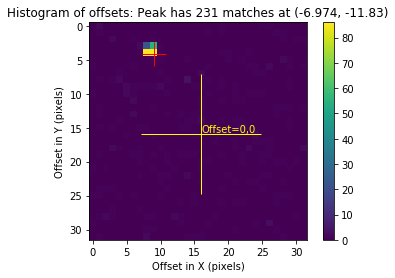

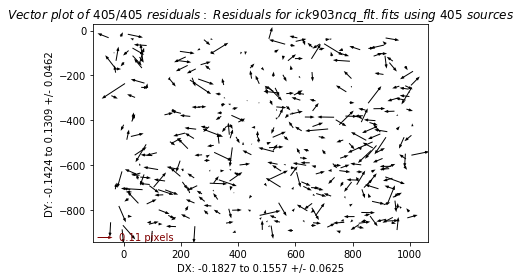

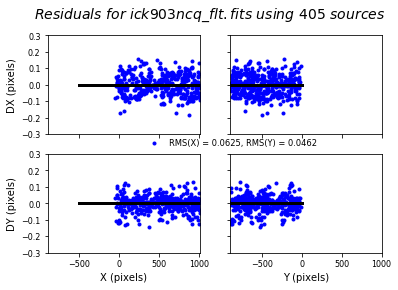

In [6]:
tweakreg.TweakReg('*flt.fits',
                  imagefindcfg={'threshold': 50, 'conv_width': 2.5},
                  expand_refcat=True,
                  enforce_user_order=False,
                  shiftfile=True,
                  outshifts='shift160_flt.txt',
                  searchrad=2.0,
                  ylimit=0.3,
                  updatehdr=True,
                  reusename=True,
                  wcsname='IR_FLT',
                  interactive=False)

## 4b. Inspect the shift file to verify the pointing residuals 

With the `threshold` parameter set to 50 sigma, TweakReg finds ~500 objects per FLC image, matches the individual catalogs, and computes residual shifts between exposures. These offsets (given in pixels at the native IR scale=0.1283”/pixel) are recorded in an output “shift file” which is shown below.  Note that the fourth row of the shift file corresponds to the reference image ‘ick902neq_flt.fits’ which was automatically selected by TweakReg. The computed offsets reflect updates to the header WCS required to correct for small pointing errors.

In [7]:
shift_table = Table.read('shift160_flt.txt',
                         format='ascii.no_header', 
                         names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])

formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

<Table length=8>
       file           dx      dy     rot    scale    xrms    yrms 
      str18        float64 float64 float64 float64 float64 float64
------------------ ------- ------- ------- ------- ------- -------
ick901hzq_flt.fits   -0.16    0.42 359.999 1.00008    0.06    0.04
ick901i7q_flt.fits   -0.21    0.37   0.001 0.99993    0.06    0.05
ick902n9q_flt.fits    0.03    0.09 360.000 1.00000    0.06    0.04
ick902neq_flt.fits    0.00    0.00   0.000 1.00000    0.00    0.00
ick903n4q_flt.fits   -6.98  -11.97 359.999 1.00000    0.06    0.05
ick903ncq_flt.fits   -7.02  -12.04 359.999 1.00001    0.06    0.05
ick904obq_flt.fits   -8.75  -12.12 359.997 0.99992    0.05    0.04
ick904ogq_flt.fits   -8.79  -12.22 359.998 1.00007    0.06    0.04

The expected pointing accuracy for various observing scenerios is summarized in the DrizzlePac Handbook [Appendix B](http://documents.stsci.edu/hst/HST_overview/documents/DrizzlePac/AppendixB2.html). Exposures making up visit-level drizzled products are typically aligned to 2-5 milliarcsecond (mas) accuracy with fine-lock on 2 guide stars. The shift file above confirms this, with offsets (dx,dy) between pairs of exposures in the same visit visit averaging ~0.05 IR pixels (6 mas). For different visits using the same set of guide stars, offsets of ~50-100 mas (0.6-1.2 IR pixels are expected. For visits with different sets of guide stars, the pointing accuracy is typically 0.2-0.5 arcseconds. 

The cell below shows how to check the image header for the 'Dominant' and 'Secondary' guide stars used. Since the M16 tiles (visits) each used different guide star pairs, the relatively large offsets (>1 arcsec) required for visits 03 and 04 to match the visit 02 reference image are not surprising, though are larger than expected. Note that the TweakReg `searchrad` parameter was increased to 2.0" from the default value of 1.0" to allow TweakReg to find the correct fit for these visits.

In [8]:
collect_spt = ImageFileCollection('./', glob_include="ick9*0_spt.fits", ext=0,
                                  keywords=["asn_id", "config", "dgestar", "sgestar"])
table_spt = collect_spt.summary
table_spt

<Table masked=True length=8>
       file          asn_id    config    dgestar      sgestar   
      str18           str9      str9      str12        str12    
------------------ --------- --------- ------------ ------------
ick901030_spt.fits ICK901030   WFC3/IR S9KJ000767F1 S9KI000263F2
ick902030_spt.fits ICK902030   WFC3/IR S9KI000192F2 S9KJ000745F1
ick903030_spt.fits ICK903030   WFC3/IR S9KI000192F2 S9KJ000768F1
ick904030_spt.fits ICK904030   WFC3/IR S9KJ004094F1 S9KI009737F2
ick905040_spt.fits ICK905040 WFC3/UVIS S9KJ000767F1 S9KI000263F2
ick906040_spt.fits ICK906040 WFC3/UVIS S9KI000192F2 S9KJ000753F1
ick907040_spt.fits ICK907040 WFC3/UVIS S9KI000248F2 S9KJ003951F1
ick908040_spt.fits ICK908040 WFC3/UVIS S9KJ004094F1 S9KI009737F2

With `enforce_user_order='True'`, the FLC files were aligned in the order shown below. The exposure v02b was automatically selected as the reference and then v02a was selected as the image with the most overlap on the sky. The two input catalogs had 601 and 574 sources, respectively, and this gave 483 matches for the two exposures, after sigma-clipping. The reference catalog was then expanded by adding 73 new objects from the dithered exposure v02a to the matched catalog for a total of 674 sources. 

TweakReg next moved over to tile 04 and to align exposure v04a to the expanded catalog. In the overlap region between tiles, 63 matches were found along the upper edge of v04a. The reference catalog was expanded once again, adding the 411 sources from v04a to give a total of 1087 sources. Now when v04b is aligned, the number of matches is 388, since the expanded catalog now includes v04a. TweakReg continues in this way until all input frames are aligned to the expanded catalog, and the number of matches for each exposure is listed in the ascii table below. 

## 4c. Inspect the IR fits

To verify that TweakReg obtained a good fit between matched source catalogs, it is useful to inspect the results before updating the image header WCS. Below sources matched with the reference frame (v02b) are overplotted on the first input image (v02a). It can be useful to check that TweakReg locked onto stars and not hot pixels or other detector artifacts before proceeding. Next, the vector residuals plot is displayed and checked for any systematics. Finally, the 4-panel plot of fit residuals: dx, dy vs X and Y is inspected to verify that the residuals cluster around zero.   

Text(0.5, 1.0, 'Match: v02a to v02b(Ref)')

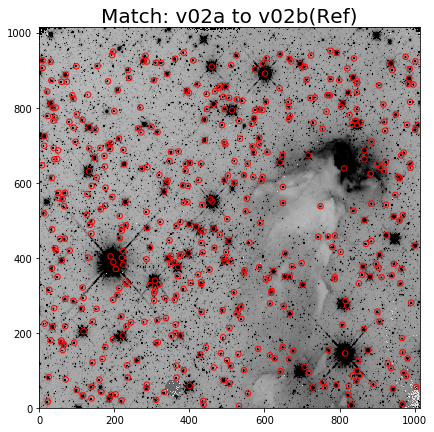

In [9]:
# v02a matches
plt.figure(figsize = (20, 7))
data = fits.open('ick902n9q_flt.fits')['SCI', 1].data
zscale = ZScaleInterval()
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick902n9q_flt_catalog_fit.match')  # load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v02a to v02b(Ref)', fontsize=20)

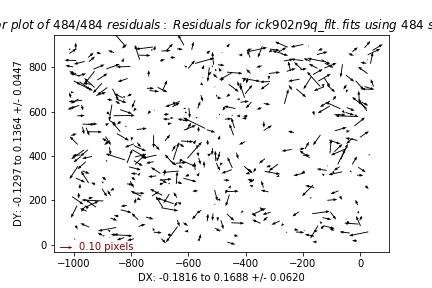

In [10]:
# v02a vector residuals
Image(filename='vector_ick902n9q_flt.png', width=500, height=300)

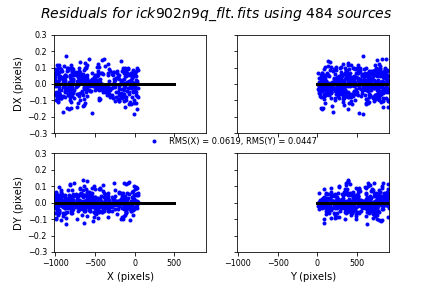

In [11]:
# v02a fit residuals
Image(filename='residuals_ick902n9q_flt.png', width=500, height=300)

Text(0.5, 1.0, 'Match: v04a to v02b(Ref)')

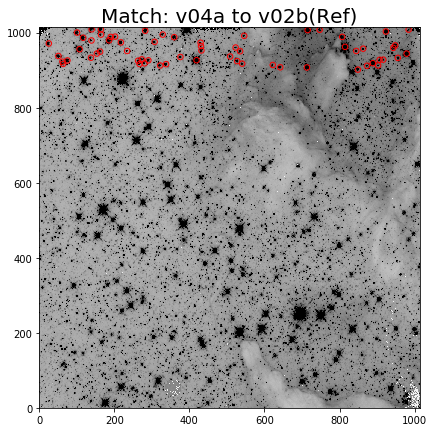

In [12]:
# v04a matches (Edge overlap region only)
plt.figure(figsize = (20, 7))
data = fits.open('ick904obq_flt.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick904obq_flt_catalog_fit.match')  # load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v04a to v02b(Ref)', fontsize=20)

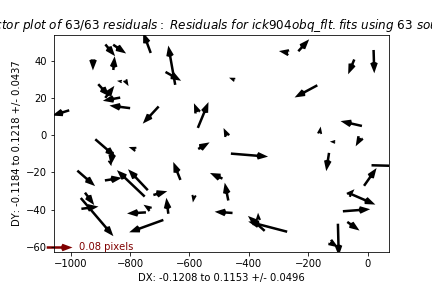

In [13]:
# v04a vector residuals (Edge gives narrow range of Y-values)
Image(filename='vector_ick904obq_flt.png', width=500, height=300)

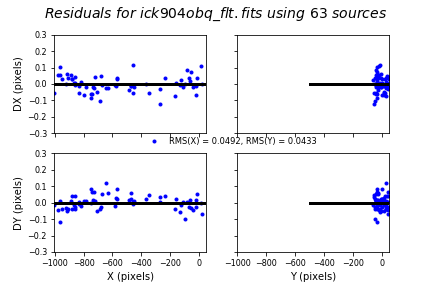

In [14]:
# v04a fit residuals (Edge gives narrow range of Y-values)
Image(filename='residuals_ick904obq_flt.png', width=500, height=300)

Text(0.5, 1.0, 'Match: v04b to v02b(Ref)')

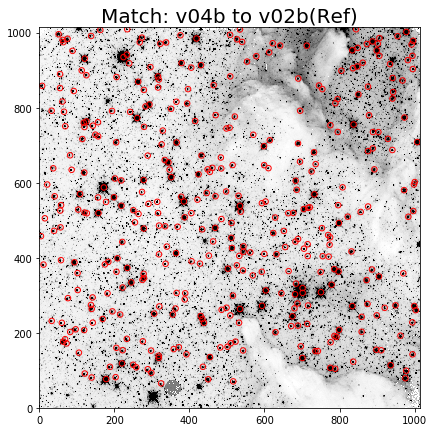

In [15]:
# v04b matches (Full image since v04a already aligned)
plt.figure(figsize = (20, 7))
data = fits.open('ick904ogq_flt.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick904ogq_flt_catalog_fit.match')  # load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v04b to v02b(Ref)', fontsize=20)

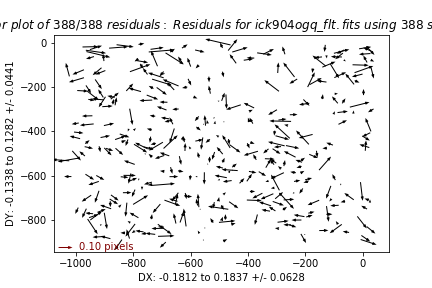

In [16]:
# v04b vector residuals
Image(filename='vector_ick904ogq_flt.png', width=500, height=300)

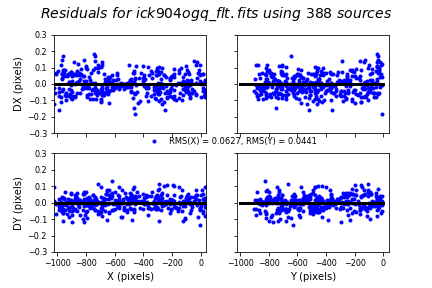

In [17]:
# v04b fit residuals
Image(filename='residuals_ick904ogq_flt.png', width=500, height=300)

Text(0.5, 1.0, 'Match: v01a to v02b(Ref)')

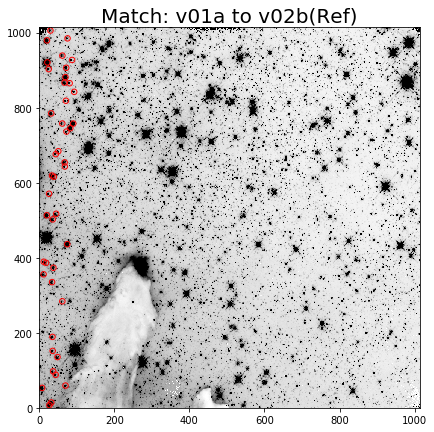

In [18]:
# v01a matches (Edge overlap region only)
plt.figure(figsize = (20, 7))
data = fits.open('ick901hzq_flt.fits')['SCI',1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin = 'lower', vmin = z1, vmax = z2)
match_tab = ascii.read('ick901hzq_flt_catalog_fit.match')                 #load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s = 30, edgecolor = 'r', facecolor = 'None')
plt.ylim(0,1014)
plt.xlim(0,1014)
plt.title('Match: v01a to v02b(Ref)', fontsize=20)

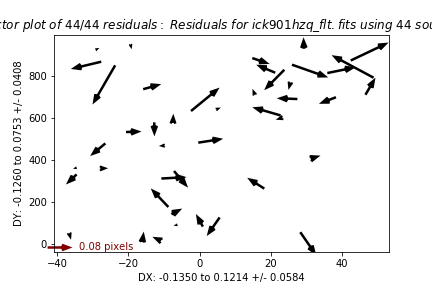

In [19]:
# v01a vector residuals (Left edge gives narrow range of X-values)
Image(filename='vector_ick901hzq_flt.png', width=500, height=300)

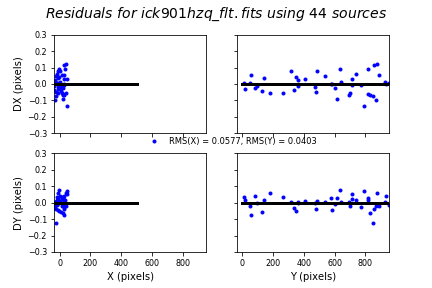

In [20]:
# v01a fit residuals (Left edge gives narrow range of X-values)
Image(filename='residuals_ick901hzq_flt.png', width=500, height=300)

Text(0.5, 1.0, 'Match: v01b to v02b(Ref)')

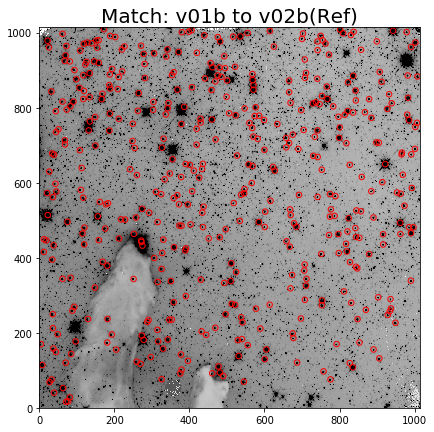

In [21]:
# v01b matches (Full image since v01a already aligned)

plt.figure(figsize = (20,7))
data = fits.open('ick901i7q_flt.fits')['SCI',1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin = 'lower', vmin = z1, vmax = z2)
match_tab = ascii.read('ick901i7q_flt_catalog_fit.match')                 #load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s = 30, edgecolor = 'r', facecolor = 'None')
plt.ylim(0,1014)
plt.xlim(0,1014)
plt.title('Match: v01b to v02b(Ref)', fontsize=20)

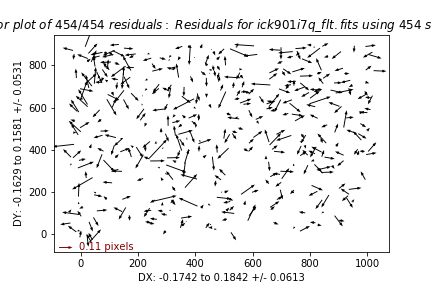

In [22]:
# v01b vector residuals
Image(filename='vector_ick901i7q_flt.png', width=500, height=300)

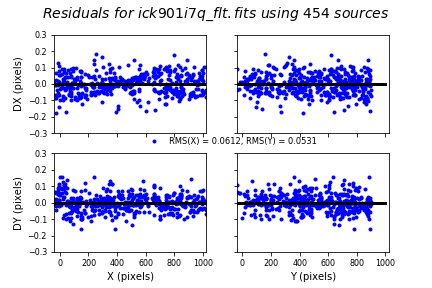

In [23]:
# v01b fit residuals
Image(filename='residuals_ick901i7q_flt.png', width=500, height=300)

Text(0.5, 1.0, 'Match: v03a to v02b(Ref)')

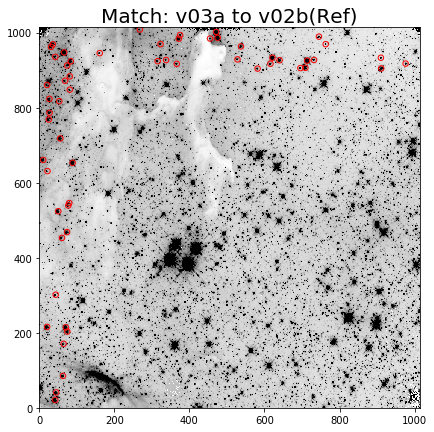

In [24]:
# v03a matches (Top and left edge overlap regions only)
plt.figure(figsize = (20, 7))
data = fits.open('ick903n4q_flt.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick903n4q_flt_catalog_fit.match')  # load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v03a to v02b(Ref)', fontsize=20)

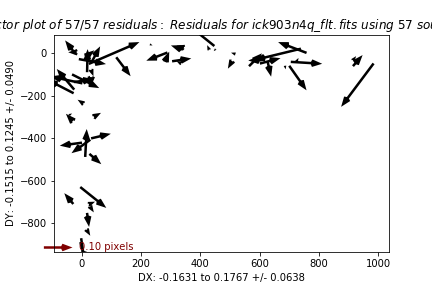

In [25]:
# v03a vector residuals (Top and left edges)
Image(filename='vector_ick903n4q_flt.png', width=500, height=300)

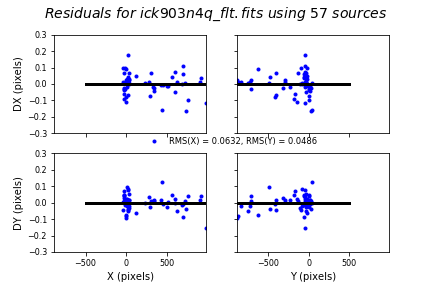

In [26]:
# v03a fit residuals
Image(filename='residuals_ick903n4q_flt.png', width=500, height=300)

Text(0.5, 1.0, 'Match: v03b to v02b(Ref)')

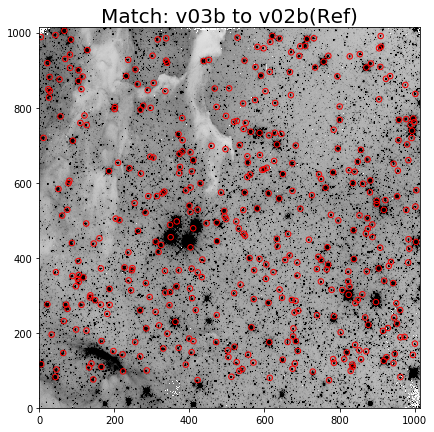

In [27]:
# v03b matches (Full image since v03a already aligned)
plt.figure(figsize = (20, 7))
data = fits.open('ick903ncq_flt.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick903ncq_flt_catalog_fit.match')                 #load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v03b to v02b(Ref)', fontsize=20)

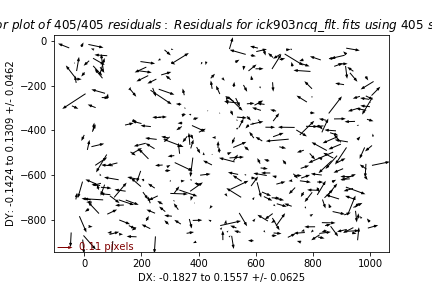

In [28]:
# v03b vector residuals
Image(filename='vector_ick903ncq_flt.png', width=500, height=300)

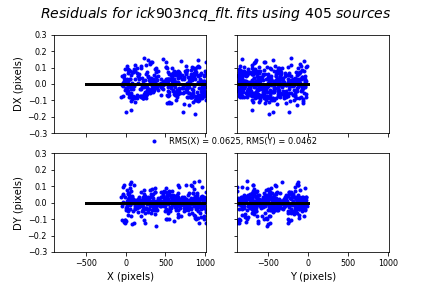

In [29]:
# v03b fit residuals
Image(filename='residuals_ick903ncq_flt.png', width=500, height=300)

The dx,dy residuals for all IR exposures are all clustered around dx,dy=0 and have an RMS less than 0.1 pixels, indicating a good fit. If the alignment needs to be fine-tuned, changing the parameters `threshold`, `sigma`, and `searchrad` may help TweakReg to lock onto an accurate solution. 

# 5. Mosaicking Features in AstroDrizzle

AstroDrizzle now makes it easier for users to match the sky background when tiling together large mosaics. In prior versions of the software, the sky background was based on clipped statistics in each image separately. The sky background was measured for each chip and the lowest sky value (in electrons/arcsec^2) among all of the chips was adopted. For observations of sparse fields, this approach generally works well. However, when large extended objects fill the detector, there is no true 'blank sky' and the background value will be an overestimate. Additionally, when extended targets are observed as mosaics (e.g. with large dithers), the 'scene' can change significantly between exposures and bias the background estimate.

An error in determining the sky background may in turn impact the cosmic ray rejection, and if severe enough, the resulting photometry. Additionally, by not properly matching the sky background before combining frames, correlated noise will be added to the final drizzled products when differences in the background levels are significant. Until now, the recommended workaround has been for users to give AstroDrizzle an ASCII file (`skyfile`) containing user-defined background values. 

AstroDrizzle now features several new options for computing the sky. One of these, `skymethod='match'`, is useful for “equalizing” the sky background across large mosaics. This method computes differences in sky values using only pixels in common between images. The sky values will then be set relative to the value computed for the input frame with the lowest sky value for which the MDRIZSKY keyword will be set to 0. In this way, the sky background is not removed, but instead equalized before the data are combined. For more details on the sky matching functions used by AstroDrizzle, see the following [webpage](https://stsci-skypac.readthedocs.io/en/latest/skymatch.html).

## 5a. Drizzle the IR/F160W Mosaic

Now AstroDrizzle can be used to combine the full set of F160W frames. In this case the final orientation has been set to -35 degrees so that the pillars will be oriented vertically. Note that users must first set the parameter `final_wcs='True'` in order to turn on parameters in AstroDrizzle’s step 7a: `Custom WCS for Final Output`. For these observations, the IR scale (0.08”/pixel) is chosen to be exactly twice that for the UVIS mosaics (0.04”/pixel) by setting `final_scale=0.08`, and the drizzled images have been oversized slightly to match the sky area on the sky covered by the UVIS. The sky background may be equalized across mosaic tiles by setting the parameter `skymethod='match'`.
   
The parameter `final_bits` defines which DQ flags in the FLT image to treat as good. All other pixels with non-zero DQ values will be assumed to be bad and rejected from the final mosaic. For IR data, these two parameters are typically set to 64+512 in the pipeline, corresponding to warm pixels and IR blobs. This program included a blob dither, however, and so the 512 flag may be removed from the list of good DQ values such that these pixels will be replaced with non-flagged pixels from the accompanying dithered pair. 

For IR data, cosmic-rays have already rejected via the 'up-the-ramp' fitting by calwf3, so Steps 3, 4, 5, 6 in AstroDrizzle have been turned off when combining the FLT exposures.  See [this reference](https://drizzlepac.readthedocs.io/en/deployment/astrodrizzle.html) for more information about the various input parameters to AstroDrizzle.

In [30]:
astrodrizzle.AstroDrizzle('*flt.fits',
                          output='f160w',
                          preserve=False,
                          clean=True,
                          build=False,
                          context=False,
                          skymethod='match', 
                          driz_separate=False,
                          median=False,
                          blot=False,
                          driz_cr=False,
                          final_bits='64',
                          final_wcs=True,
                          final_scale=0.08,
                          final_rot=-35,
                          final_ra=274.721587,
                          final_dec=-13.841549,
                          final_outnx=4000,
                          final_outny=4500)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.1.3 (2019-11-06 14:37:50 -0500) started at: 01:15:12.141 (18/12/2019)


AstroDrizzle Version 3.1.3 (2019-11-06 14:37:50 -0500) started at: 01:15:12.141 (18/12/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.astrodrizzle:3.7.5 (default, Oct 25 2019, 10:52:18) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.17.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 3.2.3 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.5.3 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  01:15:12.147 (18/12/2019)


==== Processing Step  Initialization  started at  01:15:12.147 (18/12/2019)


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_drz.fits


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:# “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


INFO:drizzlepac.processInput:#  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


INFO:drizzlepac.processInput:#  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.000813768256729454


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.05903964145806256


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01437647960035831


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.07885785050481073


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:No context image will be created for ick901hzq_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick901i7q_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick902n9q_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick902neq_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick903n4q_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick903ncq_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick904obq_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick904ogq_flt.fits


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick901hzq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick901i7q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick902n9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick902neq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick903n4q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick903ncq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick904obq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick904ogq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:drizzlepac.imageObject:No context image will be created for f160w_drz.fits


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 274.721587  -13.841549  


CRVAL : 274.721587  -13.841549  


INFO:astropy.wcs.wcs:CRPIX : 2000.5  2250.5  


CRPIX : 2000.5  2250.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -1.8203378761977594e-05  -1.2746143030023248e-05  


CD1_1 CD1_2  : -1.8203378761977594e-05  -1.2746143030023248e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -1.2746143030023248e-05  1.8203378761977594e-05  


CD2_1 CD2_2  : -1.2746143030023248e-05  1.8203378761977594e-05  


INFO:astropy.wcs.wcs:NAXIS : 4000  4500


NAXIS : 4000  4500


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 213 Mb.


*  Estimated memory usage:  up to 213 Mb.


INFO:drizzlepac.processInput:*  Output image size:       4000 X 4500 pixels. 


*  Output image size:       4000 X 4500 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 205 Mb. 


*  Output image file:       ~ 205 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  01:15:13.283 (18/12/2019)


==== Processing Step  Initialization  finished at  01:15:13.283 (18/12/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	False


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  01:15:13.292 (18/12/2019)


==== Processing Step  Static Mask  started at  01:15:13.292 (18/12/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  4.611537;   rms = 2.242564;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  4.673553;   rms = 2.203933;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  6.007894;   rms = 3.505459;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  5.865264;   rms = 3.467553;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  6.077302;   rms = 2.185454;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  6.019388;   rms = 2.174801;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  5.889317;   rms = 2.044828;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  5.817121;   rms = 1.974546;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3IR_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  01:15:13.494 (18/12/2019)


==== Processing Step  Static Mask  finished at  01:15:13.494 (18/12/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  01:15:13.497 (18/12/2019)


==== Processing Step  Subtract Sky  started at  01:15:13.497 (18/12/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	match


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2019-12-18 01:15:13.641152


***** skymatch started on 2019-12-18 01:15:13.641152


INFO:stsci.skypac.utils:      Version 1.0.4 (2019-05-30 14:31:23 -0400)


      Version 1.0.4 (2019-05-30 14:31:23 -0400)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick901hzq_flt.fits'


   **  Input image: 'ick901hzq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick901hzq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick901hzq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick901i7q_flt.fits'


   **  Input image: 'ick901i7q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick901i7q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick901i7q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick902n9q_flt.fits'


   **  Input image: 'ick902n9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick902n9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick902n9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick902neq_flt.fits'


   **  Input image: 'ick902neq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick902neq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick902neq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick903n4q_flt.fits'


   **  Input image: 'ick903n4q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick903n4q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick903n4q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick903ncq_flt.fits'


   **  Input image: 'ick903ncq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick903ncq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick903ncq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick904obq_flt.fits'


   **  Input image: 'ick904obq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick904obq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick904obq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick904ogq_flt.fits'


   **  Input image: 'ick904ogq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick904ogq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick904ogq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick901hzq_flt.fits


   *   Image: ick901hzq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick901i7q_flt.fits


   *   Image: ick901i7q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick902n9q_flt.fits


   *   Image: ick902n9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick902neq_flt.fits


   *   Image: ick902neq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick903n4q_flt.fits


   *   Image: ick903n4q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick903ncq_flt.fits


   *   Image: ick903ncq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick904obq_flt.fits


   *   Image: ick904obq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick904ogq_flt.fits


   *   Image: ick904ogq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick901hzq_flt.fits['SCI',1]' SKY = 0.909056 [brightness units]


   *   Image 'ick901hzq_flt.fits['SCI',1]' SKY = 0.909056 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0149522


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0149522


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick901i7q_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'ick901i7q_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick902n9q_flt.fits['SCI',1]' SKY = 5.1395 [brightness units]


   *   Image 'ick902n9q_flt.fits['SCI',1]' SKY = 5.1395 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0845349


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0845349


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick902neq_flt.fits['SCI',1]' SKY = 4.33121 [brightness units]


   *   Image 'ick902neq_flt.fits['SCI',1]' SKY = 4.33121 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0712401


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0712401


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick903n4q_flt.fits['SCI',1]' SKY = 6.07881 [brightness units]


   *   Image 'ick903n4q_flt.fits['SCI',1]' SKY = 6.07881 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0999846


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0999846


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick903ncq_flt.fits['SCI',1]' SKY = 3.66233 [brightness units]


   *   Image 'ick903ncq_flt.fits['SCI',1]' SKY = 3.66233 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0602382


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0602382


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick904obq_flt.fits['SCI',1]' SKY = 7.80339 [brightness units]


   *   Image 'ick904obq_flt.fits['SCI',1]' SKY = 7.80339 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.128351


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.128351


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick904ogq_flt.fits['SCI',1]' SKY = 5.39118 [brightness units]


   *   Image 'ick904ogq_flt.fits['SCI',1]' SKY = 5.39118 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0886744


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0886744


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-12-18 01:15:17.841066


***** skymatch ended on 2019-12-18 01:15:17.841066


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:04.199914


TOTAL RUN TIME: 0:00:04.199914


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  01:15:17.998 (18/12/2019)


==== Processing Step  Subtract Sky  finished at  01:15:17.998 (18/12/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  01:15:18.001 (18/12/2019)


==== Processing Step  Separate Drizzle  started at  01:15:18.001 (18/12/2019)


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  01:15:18.002 (18/12/2019)


==== Processing Step  Separate Drizzle  finished at  01:15:18.002 (18/12/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  01:15:18.004 (18/12/2019)


==== Processing Step  Create Median  started at  01:15:18.004 (18/12/2019)


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  01:15:18.006 (18/12/2019)


==== Processing Step  Blot  started at  01:15:18.006 (18/12/2019)


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  01:15:18.008 (18/12/2019)


==== Processing Step  Blot  finished at  01:15:18.008 (18/12/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  01:15:18.009 (18/12/2019)


==== Processing Step  Driz_CR  started at  01:15:18.009 (18/12/2019)


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  01:15:18.011 (18/12/2019)


==== Processing Step  Final Drizzle  started at  01:15:18.011 (18/12/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	True


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 274.721587  -13.841549  


CRVAL : 274.721587  -13.841549  


INFO:astropy.wcs.wcs:CRPIX : 2000.5  2250.5  


CRPIX : 2000.5  2250.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -1.8203378761977594e-05  -1.2746143030023248e-05  


CD1_1 CD1_2  : -1.8203378761977594e-05  -1.2746143030023248e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -1.2746143030023248e-05  1.8203378761977594e-05  


CD2_1 CD2_2  : -1.2746143030023248e-05  1.8203378761977594e-05  


INFO:astropy.wcs.wcs:NAXIS : 4000  4500


NAXIS : 4000  4500


INFO:drizzlepac.adrizzle:-Drizzle input: ick901hzq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.014952 to ick901hzq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick901i7q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ick901i7q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick902n9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.084535 to ick902n9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick902neq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.071240 to ick902neq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick903n4q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.099985 to ick903n4q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick903ncq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.060238 to ick903ncq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick904obq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.128351 to ick904obq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick904ogq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.088674 to ick904ogq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_drz_sci.fits


-Generating simple FITS output: f160w_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_drz_sci.fits


Writing out image to disk: f160w_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_drz_wht.fits


Writing out image to disk: f160w_drz_wht.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  01:15:22.731 (18/12/2019)


==== Processing Step  Final Drizzle  finished at  01:15:22.731 (18/12/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.1.3 is finished processing at 01:15:22.734 (18/12/2019).


AstroDrizzle Version 3.1.3 is finished processing at 01:15:22.734 (18/12/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          1.1355 sec.


         Initialization          1.1355 sec.


INFO:drizzlepac.util:            Static Mask          0.2027 sec.


            Static Mask          0.2027 sec.


INFO:drizzlepac.util:           Subtract Sky          4.5016 sec.


           Subtract Sky          4.5016 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0016 sec.


       Separate Drizzle          0.0016 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0017 sec.


                   Blot          0.0017 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          4.7198 sec.


          Final Drizzle          4.7198 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          10.5628 sec.


                  Total          10.5628 sec.


INFO:drizzlepac.imageObject:Removing intermediate files for ick901hzq_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick901i7q_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick902n9q_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick902neq_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick903n4q_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick903ncq_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick904obq_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick904ogq_flt.fits


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


## 5b. Display the combined DRZ science and weight images 

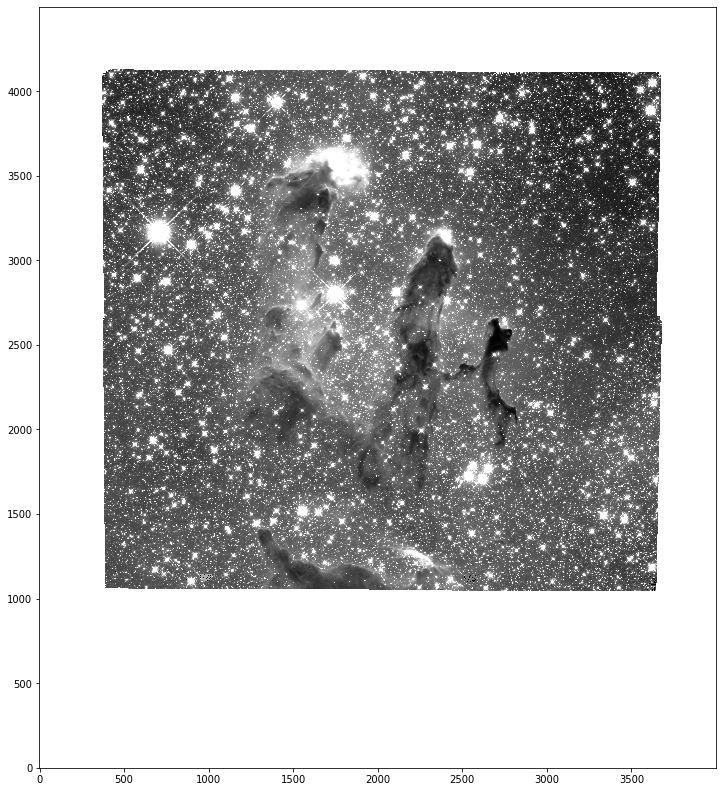

In [31]:
sci = fits.getdata('f160w_drz_sci.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=1, vmax=6, cmap='Greys_r', origin='lower')

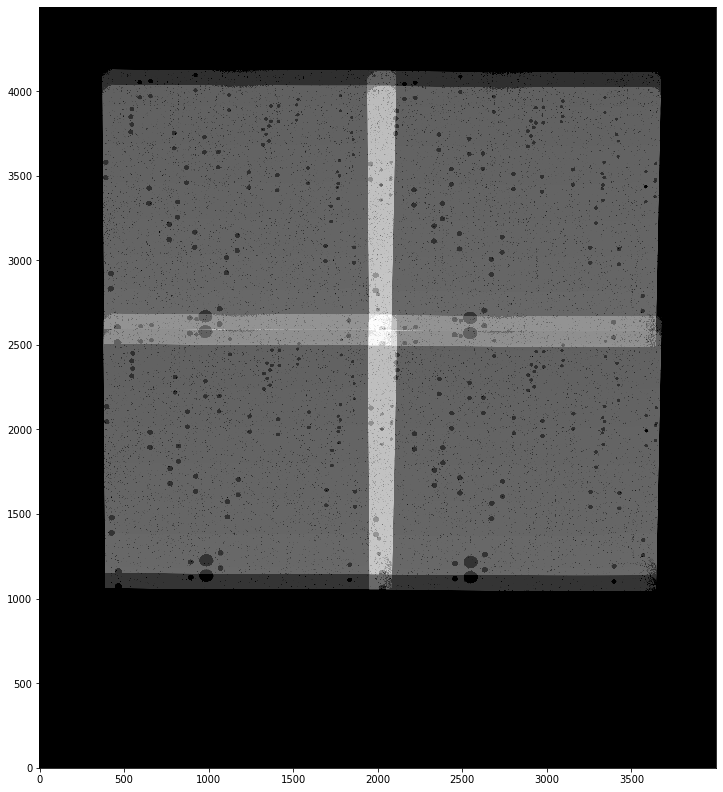

In [32]:
wht = fits.getdata('f160w_drz_wht.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(wht, vmin=0, vmax=1700, cmap='Greys_r', origin='lower')

# 6. Align the UVIS FLC frames to the IR mosaic

The F160W drizzled mosaic defines the reference frame for aligning the UVIS filters. In [ISR 2015-09](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-09.pdf), the UVIS visit-level DRC frames were aligned directly to the IR reference image, and this approach was chosen because the long UVIS exposures contain numerous cosmic-rays and relatively few point sources. The Drizzlepac task TweakBack was then used to propagate the updated WCS from the drizzled image header back to the individual FLC input frames making up each association prior to drizzling.

In this notebook, the FLC frames may be aligned directly to the IR mosaic by making use of a new parameter in TweakReg which allows for specific flags in the DQ array of the FLC frames to be used or ignored. The `imagefindpars` parameter `dqbits` may be prepended with ‘~’ to the string value to indicate which DQ flags to consider as "bad" pixels. For example, when deriving source catalogs, Tweakreg will ignore any pixels flagged as cosmic-ray flags in the MAST visit-level drizzled data products when `dqbits` is set to ~4096. This dramatically cuts down the number of false detections due to cosmic rays in the input FLC science arrays. More details on `imagefindpars` options may be found on the following [webpage](https://drizzlepac.readthedocs.io/en/deployment/imagefindpars.html). 

In this example, the `threshold` value was manually adjusted to get ~50 matches per UVIS exposure. Note that setting the `threshold` to a very low value does not necessarily translate to a better solution, since all sources are weighted equally when computing fits to match catalogs. This is especially relevant for UVIS data where CTE tails can shift the centroid position slightly along the readout direction for faint sources and potentially bias the fit.

In [33]:
tweakreg.TweakReg('*_flc.fits',
                  enforce_user_order=False,
                  imagefindcfg={'threshold': 200, 'conv_width': 3.5, 'dqbits': ~4096},
                  refimage='f160w_drz_sci.fits', 
                  refimagefindcfg={'threshold': 50, 'conv_width': 2.5},
                  shiftfile=True,
                  outshifts='shift657_flc.txt',
                  searchrad=5.0,
                  ylimit=0.6,
                  updatehdr=True,
                  wcsname='UVIS_FLC',
                  reusename=True,
                  interactive=False)

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 01:15:24.209 (18/12/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 01:15:24.209 (18/12/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.5 (default, Oct 25 2019, 10:52:18) 


3.7.5 (default, Oct 25 2019, 10:52:18) 


INFO:drizzlepac.util:numpy Version -> 1.17.4 


numpy Version -> 1.17.4 


INFO:drizzlepac.util:astropy Version -> 3.2.3 


astropy Version -> 3.2.3 


INFO:drizzlepac.util:stwcs Version -> 1.5.3 


stwcs Version -> 1.5.3 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	False


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	input :	*_flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	f160w_drz_sci.fits


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    ick905k5q_flc.fits


    ick905k5q_flc.fits


INFO:drizzlepac.tweakreg:    ick905keq_flc.fits


    ick905keq_flc.fits


INFO:drizzlepac.tweakreg:    ick905knq_flc.fits


    ick905knq_flc.fits


INFO:drizzlepac.tweakreg:    ick906kwq_flc.fits


    ick906kwq_flc.fits


INFO:drizzlepac.tweakreg:    ick906l5q_flc.fits


    ick906l5q_flc.fits


INFO:drizzlepac.tweakreg:    ick906leq_flc.fits


    ick906leq_flc.fits


INFO:drizzlepac.tweakreg:    ick907nkq_flc.fits


    ick907nkq_flc.fits


INFO:drizzlepac.tweakreg:    ick907o1q_flc.fits


    ick907o1q_flc.fits


INFO:drizzlepac.tweakreg:    ick907ouq_flc.fits


    ick907ouq_flc.fits


INFO:drizzlepac.tweakreg:    ick908pbq_flc.fits


    ick908pbq_flc.fits


INFO:drizzlepac.tweakreg:    ick908pkq_flc.fits


    ick908pkq_flc.fits


INFO:drizzlepac.tweakreg:    ick908ptq_flc.fits


    ick908ptq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	-4097


INFO:drizzlepac.tweakreg:	enforce_user_order :	False


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*_flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	f160w_drz_sci.fits


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	200


INFO:drizzlepac.tweakreg:	updatehdr :	True


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick905k5q_flc.fits':


===  Source finding for image 'ick905k5q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick905k5q_flc.fits', EXT=('SCI', 1) started at: 01:15:24.377 (18/12/2019)


  #  Source finding for 'ick905k5q_flc.fits', EXT=('SCI', 1) started at: 01:15:24.377 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.914108


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:25.194 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 148 objects.


     Found 148 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick905k5q_flc.fits', EXT=('SCI', 2) started at: 01:15:25.258 (18/12/2019)


  #  Source finding for 'ick905k5q_flc.fits', EXT=('SCI', 2) started at: 01:15:25.258 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 11.987140


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:26.046 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 574 objects.


     Found 574 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick905k5q_flc.fits': 722


===  FINAL number of objects in image 'ick905k5q_flc.fits': 722


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick905keq_flc.fits':


===  Source finding for image 'ick905keq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick905keq_flc.fits', EXT=('SCI', 1) started at: 01:15:26.294 (18/12/2019)


  #  Source finding for 'ick905keq_flc.fits', EXT=('SCI', 1) started at: 01:15:26.294 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.909635


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:27.06 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 89 objects.


     Found 89 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick905keq_flc.fits', EXT=('SCI', 2) started at: 01:15:27.128 (18/12/2019)


  #  Source finding for 'ick905keq_flc.fits', EXT=('SCI', 2) started at: 01:15:27.128 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.073435


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:27.914 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 215 objects.


     Found 215 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick905keq_flc.fits': 304


===  FINAL number of objects in image 'ick905keq_flc.fits': 304


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick905knq_flc.fits':


===  Source finding for image 'ick905knq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick905knq_flc.fits', EXT=('SCI', 1) started at: 01:15:28.156 (18/12/2019)


  #  Source finding for 'ick905knq_flc.fits', EXT=('SCI', 1) started at: 01:15:28.156 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 16.029766


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:28.935 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 258 objects.


     Found 258 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick905knq_flc.fits', EXT=('SCI', 2) started at: 01:15:29.000 (18/12/2019)


  #  Source finding for 'ick905knq_flc.fits', EXT=('SCI', 2) started at: 01:15:29.000 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.057777


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:29.783 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 213 objects.


     Found 213 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick905knq_flc.fits': 471


===  FINAL number of objects in image 'ick905knq_flc.fits': 471


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick906kwq_flc.fits':


===  Source finding for image 'ick906kwq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick906kwq_flc.fits', EXT=('SCI', 1) started at: 01:15:30.053 (18/12/2019)


  #  Source finding for 'ick906kwq_flc.fits', EXT=('SCI', 1) started at: 01:15:30.053 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 16.643072


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:30.835 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 186 objects.


     Found 186 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick906kwq_flc.fits', EXT=('SCI', 2) started at: 01:15:30.898 (18/12/2019)


  #  Source finding for 'ick906kwq_flc.fits', EXT=('SCI', 2) started at: 01:15:30.898 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.414701


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:31.676 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 338 objects.


     Found 338 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick906kwq_flc.fits': 524


===  FINAL number of objects in image 'ick906kwq_flc.fits': 524


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick906l5q_flc.fits':


===  Source finding for image 'ick906l5q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick906l5q_flc.fits', EXT=('SCI', 1) started at: 01:15:31.911 (18/12/2019)


  #  Source finding for 'ick906l5q_flc.fits', EXT=('SCI', 1) started at: 01:15:31.911 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 16.631145


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:32.683 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 94 objects.


     Found 94 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick906l5q_flc.fits', EXT=('SCI', 2) started at: 01:15:32.746 (18/12/2019)


  #  Source finding for 'ick906l5q_flc.fits', EXT=('SCI', 2) started at: 01:15:32.746 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.561554


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:33.533 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 130 objects.


     Found 130 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick906l5q_flc.fits': 224


===  FINAL number of objects in image 'ick906l5q_flc.fits': 224


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick906leq_flc.fits':


===  Source finding for image 'ick906leq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick906leq_flc.fits', EXT=('SCI', 1) started at: 01:15:33.766 (18/12/2019)


  #  Source finding for 'ick906leq_flc.fits', EXT=('SCI', 1) started at: 01:15:33.766 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 16.691345


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:34.555 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 242 objects.


     Found 242 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick906leq_flc.fits', EXT=('SCI', 2) started at: 01:15:34.618 (18/12/2019)


  #  Source finding for 'ick906leq_flc.fits', EXT=('SCI', 2) started at: 01:15:34.618 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.747993


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:35.396 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 186 objects.


     Found 186 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick906leq_flc.fits': 428


===  FINAL number of objects in image 'ick906leq_flc.fits': 428


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick907nkq_flc.fits':


===  Source finding for image 'ick907nkq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick907nkq_flc.fits', EXT=('SCI', 1) started at: 01:15:35.644 (18/12/2019)


  #  Source finding for 'ick907nkq_flc.fits', EXT=('SCI', 1) started at: 01:15:35.644 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.998682


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:36.419 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 111 objects.


     Found 111 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick907nkq_flc.fits', EXT=('SCI', 2) started at: 01:15:36.480 (18/12/2019)


  #  Source finding for 'ick907nkq_flc.fits', EXT=('SCI', 2) started at: 01:15:36.480 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.788088


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:37.268 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 303 objects.


     Found 303 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick907nkq_flc.fits': 414


===  FINAL number of objects in image 'ick907nkq_flc.fits': 414


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick907o1q_flc.fits':


===  Source finding for image 'ick907o1q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick907o1q_flc.fits', EXT=('SCI', 1) started at: 01:15:37.511 (18/12/2019)


  #  Source finding for 'ick907o1q_flc.fits', EXT=('SCI', 1) started at: 01:15:37.511 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 18.056701


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:38.287 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 88 objects.


     Found 88 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick907o1q_flc.fits', EXT=('SCI', 2) started at: 01:15:38.347 (18/12/2019)


  #  Source finding for 'ick907o1q_flc.fits', EXT=('SCI', 2) started at: 01:15:38.347 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.742237


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:39.134 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 101 objects.


     Found 101 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick907o1q_flc.fits': 189


===  FINAL number of objects in image 'ick907o1q_flc.fits': 189


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick907ouq_flc.fits':


===  Source finding for image 'ick907ouq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick907ouq_flc.fits', EXT=('SCI', 1) started at: 01:15:39.436 (18/12/2019)


  #  Source finding for 'ick907ouq_flc.fits', EXT=('SCI', 1) started at: 01:15:39.436 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.942683


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:40.217 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 262 objects.


     Found 262 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick907ouq_flc.fits', EXT=('SCI', 2) started at: 01:15:40.279 (18/12/2019)


  #  Source finding for 'ick907ouq_flc.fits', EXT=('SCI', 2) started at: 01:15:40.279 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.810923


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:41.056 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 143 objects.


     Found 143 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick907ouq_flc.fits': 405


===  FINAL number of objects in image 'ick907ouq_flc.fits': 405


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick908pbq_flc.fits':


===  Source finding for image 'ick908pbq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick908pbq_flc.fits', EXT=('SCI', 1) started at: 01:15:41.303 (18/12/2019)


  #  Source finding for 'ick908pbq_flc.fits', EXT=('SCI', 1) started at: 01:15:41.303 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 18.698361


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:42.077 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 119 objects.


     Found 119 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick908pbq_flc.fits', EXT=('SCI', 2) started at: 01:15:42.14 (18/12/2019)


  #  Source finding for 'ick908pbq_flc.fits', EXT=('SCI', 2) started at: 01:15:42.14 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.107899


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:42.928 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 318 objects.


     Found 318 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick908pbq_flc.fits': 437


===  FINAL number of objects in image 'ick908pbq_flc.fits': 437


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick908pkq_flc.fits':


===  Source finding for image 'ick908pkq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick908pkq_flc.fits', EXT=('SCI', 1) started at: 01:15:43.180 (18/12/2019)


  #  Source finding for 'ick908pkq_flc.fits', EXT=('SCI', 1) started at: 01:15:43.180 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 18.178764


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:43.95 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 57 objects.


     Found 57 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick908pkq_flc.fits', EXT=('SCI', 2) started at: 01:15:44.017 (18/12/2019)


  #  Source finding for 'ick908pkq_flc.fits', EXT=('SCI', 2) started at: 01:15:44.017 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.168670


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:44.799 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 93 objects.


     Found 93 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick908pkq_flc.fits': 150


===  FINAL number of objects in image 'ick908pkq_flc.fits': 150


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick908ptq_flc.fits':


===  Source finding for image 'ick908ptq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick908ptq_flc.fits', EXT=('SCI', 1) started at: 01:15:45.029 (18/12/2019)


  #  Source finding for 'ick908ptq_flc.fits', EXT=('SCI', 1) started at: 01:15:45.029 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 18.100852


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:45.808 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 182 objects.


     Found 182 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick908ptq_flc.fits', EXT=('SCI', 2) started at: 01:15:45.928 (18/12/2019)


  #  Source finding for 'ick908ptq_flc.fits', EXT=('SCI', 2) started at: 01:15:45.928 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.383158


INFO:drizzlepac.catalogs:###Source finding finished at: 01:15:46.709 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 116 objects.


     Found 116 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick908ptq_flc.fits': 298


===  FINAL number of objects in image 'ick908ptq_flc.fits': 298


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	2.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	False


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*_flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	f160w_drz_sci.fits


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	50


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.imgclasses:===  Source finding for image 'f160w_drz_sci.fits':


===  Source finding for image 'f160w_drz_sci.fits':


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


ERROR:stsci.tools.logutil.exc:An unhandled exception ocurred:
Traceback (most recent call last):
  File "/Users/etollerud/miniconda3/envs/nb-build/lib/python3.7/site-packages/drizzlepac/util.py", line 225, in wrapper
    result = func(*args, **kwargs)
  File "/Users/etollerud/miniconda3/envs/nb-build/lib/python3.7/site-packages/drizzlepac/tweakreg.py", line 370, in run
    **ref_catfile_kwargs)
  File "/Users/etollerud/miniconda3/envs/nb-build/lib/python3.7/site-packages/drizzlepac/imgclasses.py", line 188, in __init__
    catalog=source, src_find_filters=excludefile, **kwargs)
  File "/Users/etollerud/miniconda3/envs/nb-build/lib/python3.7/site-packages/drizzlepac/catalogs.py", line 72, in generateCatalog
    catalog = ImageCatalog(wcs,catalog,src_find_filters,**kwargs)
  File "/Users/etollerud/miniconda3/envs/nb-build/lib/python3.7/site-packages/drizzlepac/catalogs.py", line 447, in __init__
    self.source = fits.getdata(self.wcs.filename,ext=self.wcs.extname, memmap=False)
  File "

KeyError: "Extension ('', 1) not found."

KeyError: "Extension ('', 1) not found."

## 6a. Inspect the shift file to verify the pointing residuals 

With a `threshold` of 200 sigma, TweakReg generates catalogs with several hundred objects per UVIS image and it matches 20-70 objects to the IR reference catalog. The computed offsets written to the shift file are reported at the scale of the reference image (0.08”/pixel for the drizzled IR mosaic). Thus a fit rms ~0.20 pixels (below) at the IR scale is equivalent to an rms ~0.10 pixels at the native UVIS scale (0.04"/pixel).

Because each visit was acquired using a unique pair of Guide Stars, the three FLC exposures making up each visit should have roughly similar residual corrections to the WCS, which can be seen in the table below. Note that residual offsets for visit 05 are much larger than those found for the other three visits at nearly 3".

In [ ]:
shift_table=Table.read('shift657_flc.txt', format='ascii.no_header',
                       names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])

formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

## 6b. Inspect the UVIS fits

In [ ]:
#v06a matched sources (chip 1)
plt.figure(figsize=(20, 10))
chip1_data = fits.open('ick906l5q_flc.fits')['SCI', 2].data
z1, z2 = zscale.get_limits(chip1_data)
plt.imshow(chip1_data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick906l5q_flc_catalog_fit.match')  # load match file in astropy table
match_tab_chip1 = match_tab[match_tab['col15'] == 2]  # filter table for sources on chip 1 (on ext 4)
x_cord, y_cord = match_tab_chip1['col11'], match_tab_chip1['col12']
plt.scatter(x_cord, y_cord, s=50, edgecolor='r', facecolor='None', label='Matched Sources, Chip 1')
plt.ylim(0, 2051)
plt.xlim(0, 4096)
plt.legend(loc='best', fontsize=20)

In [ ]:
#v06a matched sources (chip 2)
plt.figure(figsize=(20, 10))
chip1_data = fits.open('ick906l5q_flc.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(chip1_data)
plt.imshow(chip1_data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick906l5q_flc_catalog_fit.match')  # load match file in astropy table
match_tab_chip2 = match_tab[match_tab['col15'] == 1]  # filter table for sources on chip 2 (on ext 1)
x_cord, y_cord = match_tab_chip2['col11'], match_tab_chip2['col12']
plt.scatter(x_cord, y_cord, s=50, edgecolor='r', facecolor='None', label='Matched Sources, Chip 2')
plt.ylim(0, 2051)
plt.xlim(0, 4096)
plt.legend(loc='best', fontsize=20)

In [ ]:
# v06a vector residuals
Image(filename='vector_ick906l5q_flc.png', width=600, height=300)

In [ ]:
# v06a fit residuals
Image(filename='residuals_ick906l5q_flc.png', width=600, height=300)

# 7. Drizzling the F657N mosaic

The full set of 12 FLC frames have now been aligned and may be drizzled to a mosaic exactly half the scale (0.04"/pixel) of the original IR mosaic (0.08"/pixel). The same output WCS paramters: `final_rot`,`final_ra`, and `final_dec` values are used, but the `final_outnx` and `final_outny` are now twice the size of the IR mosaic at 8000x9000 pixels. 

To save time for this notebook, the visit-level cosmic ray flags are assumed to be adequate, Steps 3, 4, 5, 6 are turned off, and the parameter `resetbits` is set to '0' to avoid wiping out the 4096 flags in the FLC data quality arrays. Also, the sky background levels have been provided via the skyfile parameter, but users would typically set `skymethod='match'` to compute the sky background levels. 

To further improve cosmic-ray rejection in the chip gap, AstroDrizzle may alternatively be run with all steps turned on as shown in the text below and with `resetbits=4096` to update the DQ flags. 

```
astrodrizzle.AstroDrizzle('*flc.fits',
                          output='f657n_improved',
                          preserve=False,
                          clean=False,
                          build=False,
                          context=False,
                          resetbits=4096,
                          skymethod='match',
                          combine_type='minmed',
                          final_bits='64,16',
                          final_wcs=True,
                          final_scale=0.04,
                          final_rot=-35,
                          final_ra=274.721587,
                          final_dec=-13.841549,
                          final_outnx=8000,
                          final_outny=9000)
```

In [ ]:
astrodrizzle.AstroDrizzle('*flc.fits',
                          output='f657n',
                          preserve=False,
                          clean=False,
                          build=False,
                          context=False,
                          resetbits=0,
                          skyfile='skyfile.txt',
                          driz_separate=False,
                          median=False,
                          blot=False,
                          driz_cr=False,
                          final_bits='64,16',
                          final_wcs=True,
                          final_scale=0.04,
                          final_rot=-35,
                          final_ra=274.721587,
                          final_dec=-13.841549,
                          final_outnx=8000,
                          final_outny=9000)

## 7a. Display the combined DRC science and weight images 

In [ ]:
sci = fits.getdata('f657n_drc_sci.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=0, vmax=1, cmap='Greys_r', origin='lower')

In [ ]:
sci = fits.getdata('f657n_drc_wht.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=0, vmax=10000, cmap='Greys_r', origin='lower')

# Summary

This notebook provides the methodology for creating UVIS and IR mosaics of M16, as well as recommendations for key parameters. As such, it is relevant for users combining multi-visit observations from any HST imaging program, whether mosaics or single pointings. In this example, the IR F160W mosaic was chosen to define the reference frame, since it contained the largest number of point sources, despite the pixels being undersampled. Typically, the detector with the best resolution and PSF sampling would be selected as the reference, but in this case the UVIS catalogs were too sparse.

When building up an expanded reference catalog on the sky, TweakReg was allowed to select the order in which tiles were aligned, since it made little impact on the results. For aligning mosaics with more tiles, however, users are recommended to experiment with changing the order in which images are aligned and seeing how this changes the astrometric residuals.  Generally, users are advised to start from the center of the mosaic and work their way out to avoid propogation of errors across the mosaic. 

Alternatively, mosaic tiles can be aligned directly to an absolute reference catalog such as GAIA, when a sufficient number of stars are available in the input frames for alignment. For more detail on this methodology, see the notebook 'aligning_to_catalogs.ipynb'. 

# About this Notebook

    Author: J. Mack, STScI WFC3 Team  
    Updated: December 17, 2018